In [2]:
# ignore the output of this cell
!pip install pafy youtube-dl moviepy opencv-python numpy tensorflow keras matplotlib scikit-learn pydot graphviz

In [3]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque, defaultdict
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2024-10-11 23:04:10.815249: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 23:04:10.834357: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 23:04:10.992085: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-11 23:04:11.145594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 23:04:11.250820: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

set seeds for consistency

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [9]:
model_and_dataset_path = 'convlstm_model/'

**Step 1: Download and Visualize the Data with its Labels**

[UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of realistic videos taken from youtube  The Dataset contains:

- 50 Action Categories
- 25 Groups of Videos per Action Category
- 133 Average Videos per Action Category
- 199 Average Number of Frames per Video
- 320 Average Frames Width per Video
- 240 Average Frames Height per Video
- 26 Average Frames Per Seconds per Video

In [5]:
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# Make the UCF50 directory if it doesn't exist
!mkdir -p convlstm_model/UCF50

# Extract the contents of UCF50.rar into the UCF50 folder
!unrar e UCF50.rar -y convlstm_model/UCF50/


--2024-10-11 23:04:36--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/x-rar-compressed]
Saving to: ‘UCF50.rar’

UCF50.rar            33%[=====>              ]   1.01G  4.10MB/s    in 4m 11s  

2024-10-11 23:08:41 (4.12 MB/s) - Connection closed at byte 1085324836. Retrying.

--2024-10-11 23:08:42--  (try: 2)  https://www.crcv.ucf.edu/data/UCF50.rar
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 206 Partial Content
Length: 3233554570 (3.0G), 2148229734 (2.0G) remaining [application/x-rar-compressed]
Saving to: ‘UCF50.rar’

UCF50.rar            67%[++++++======>       ]   2.02G  4.67M

Some videos: ['v_GolfSwing_g05_c02.avi', 'v_CleanAndJerk_g03_c05.avi', 'v_VolleyballSpiking_g03_c02.avi', 'v_GolfSwing_g09_c01.avi', 'v_JavelinThrow_g19_c04.avi']
Grouped: {'GolfSwing': ['v_GolfSwing_g05_c02.avi', 'v_GolfSwing_g09_c01.avi', 'v_GolfSwing_g17_c07.avi', 'v_GolfSwing_g17_c01.avi', 'v_GolfSwing_g19_c03.avi', 'v_GolfSwing_g02_c03.avi', 'v_GolfSwing_g25_c01.avi', 'v_GolfSwing_g05_c03.avi', 'v_GolfSwing_g02_c02.avi', 'v_GolfSwing_g07_c01.avi', 'v_GolfSwing_g23_c07.avi', 'v_GolfSwing_g11_c07.avi', 'v_GolfSwing_g03_c05.avi', 'v_GolfSwing_g08_c04.avi', 'v_GolfSwing_g25_c05.avi', 'v_GolfSwing_g17_c08.avi', 'v_GolfSwing_g16_c01.avi', 'v_GolfSwing_g10_c03.avi', 'v_GolfSwing_g25_c03.avi', 'v_GolfSwing_g24_c02.avi', 'v_GolfSwing_g24_c04.avi', 'v_GolfSwing_g20_c06.avi', 'v_GolfSwing_g13_c04.avi', 'v_GolfSwing_g07_c05.avi', 'v_GolfSwing_g23_c03.avi', 'v_GolfSwing_g24_c07.avi', 'v_GolfSwing_g06_c03.avi', 'v_GolfSwing_g18_c03.avi', 'v_GolfSwing_g22_c06.avi', 'v_GolfSwing_g06_c04.avi', 'v_

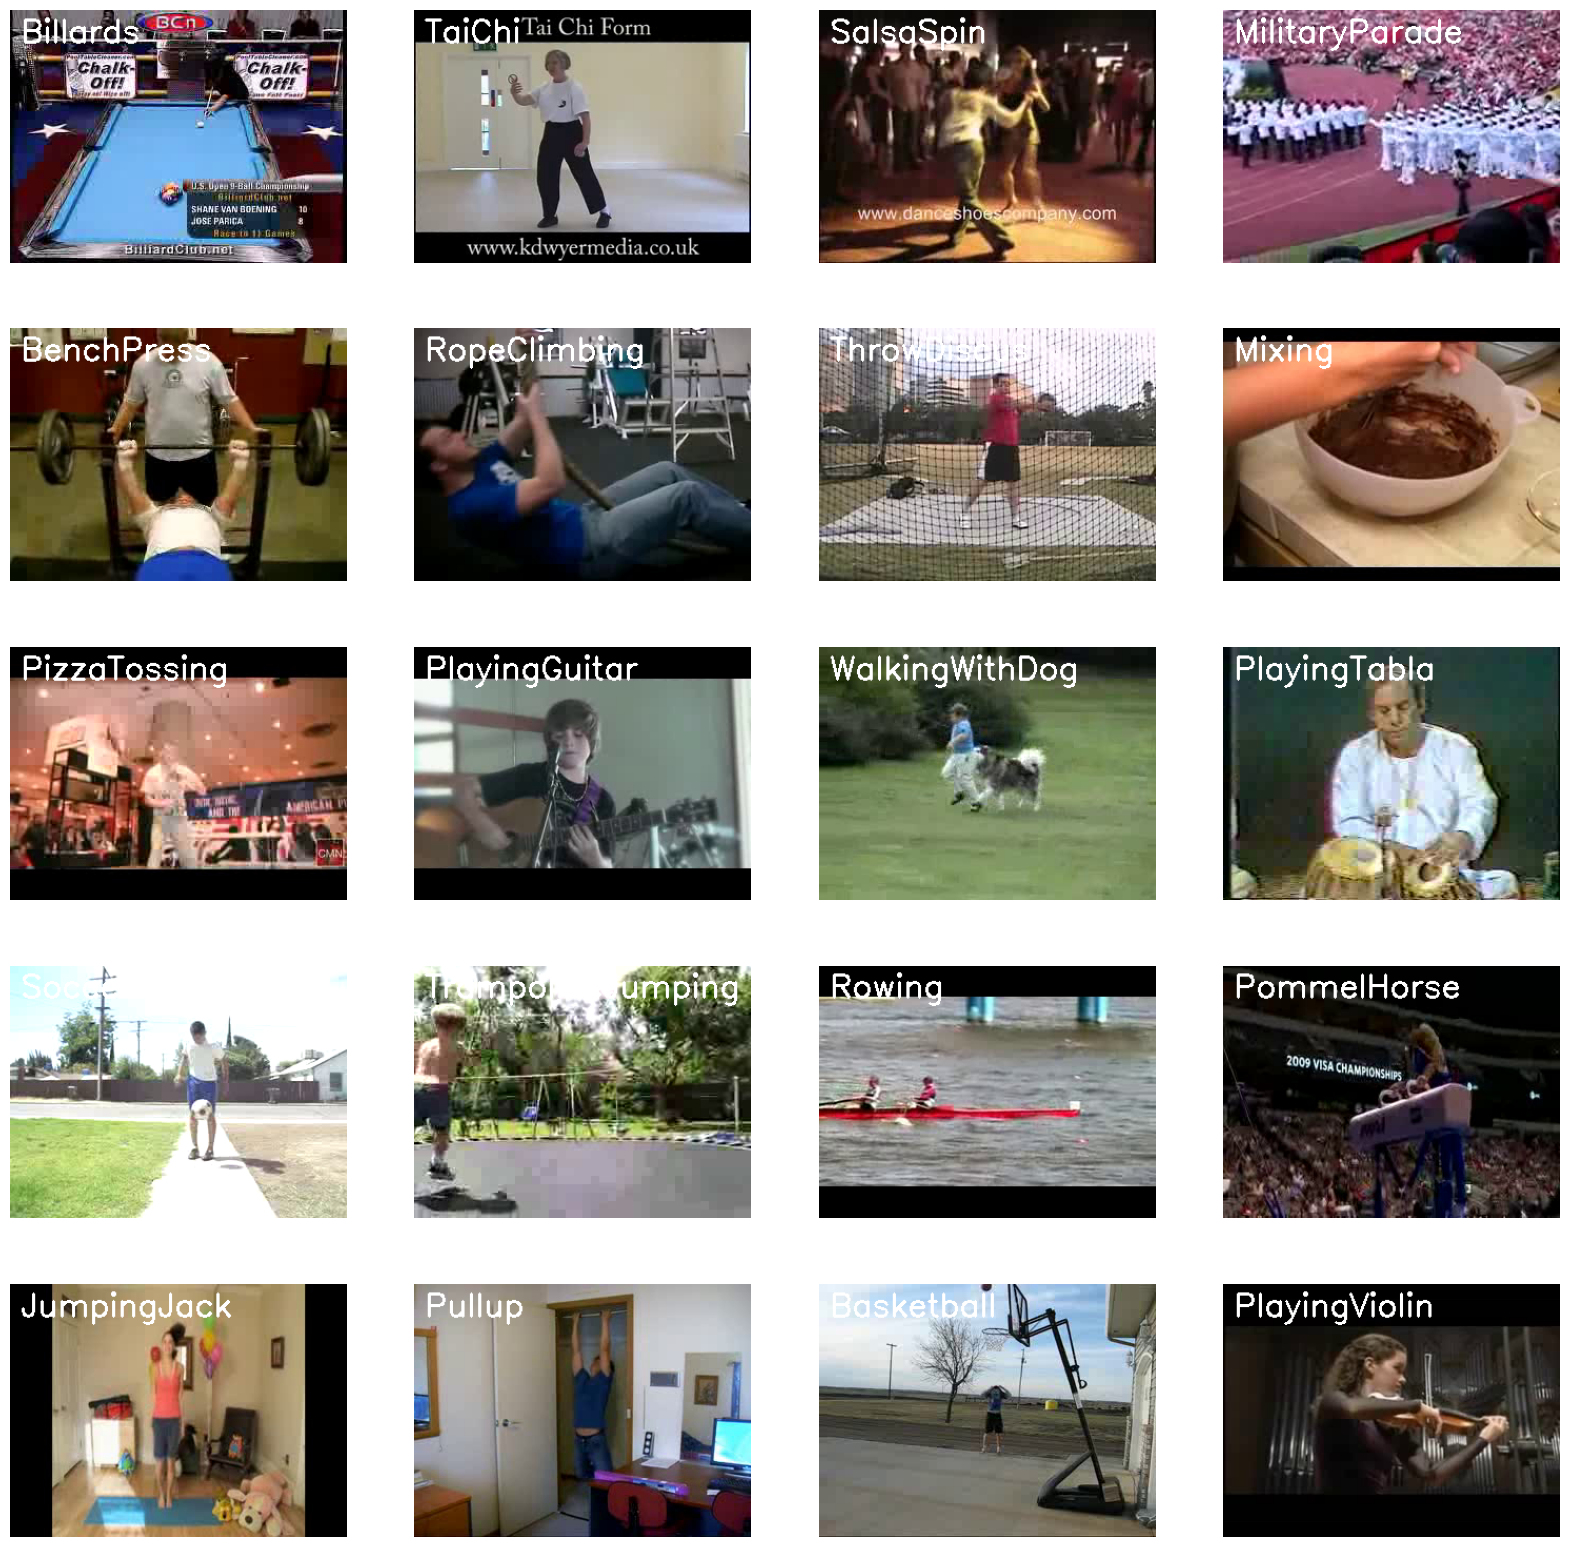

In [11]:
from __future__ import print_function
ucf50_path = model_and_dataset_path + 'dataset/UCF50'
all_videos = [name for name in os.listdir(ucf50_path) if name.endswith('.avi')]
print("Some videos:", all_videos[:5])

# Group videos by class names using a defaultdict
video_dict = defaultdict(list)
for video in all_videos:
    class_name = video.split('_')[1]
    video_dict[class_name].append(video)

print("Grouped:", dict(list(video_dict.items())[0:2]))

# the first few class names and number of videos per class
print("Classes and number of videos per class:")
for class_name, videos in list(video_dict.items())[:5]:
    print(f"{class_name}: {len(videos)} videos")

random_classes = random.sample(list(video_dict.keys()), 20)
plt.figure(figsize=(20, 20))

for counter, class_name in enumerate(random_classes, 1):
    random_video = random.choice(video_dict[class_name])
    random_video_path = os.path.join(ucf50_path, random_video)
    video_reader = cv2.VideoCapture(random_video_path)
    success, bgr_frame = video_reader.read()
    video_reader.release()
    if success:
        rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, text=class_name, org=(10, 30), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1, color=(255, 255, 255), thickness=2)

        # Plot the frame
        plt.subplot(5, 4, counter)  #a 5x4 grid for 20 frames
        plt.imshow(rgb_frame)
        plt.axis('off')

Preprocess the Datasett

In [12]:
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20 # number of frames that are going to be the sequence length for the lstm
DATASET_PATH = model_and_dataset_path + 'dataset/UCF50'

# List with names of classes used for training
CLASSES_LIST = ['WalkingWithDog', 'TaiChi', 'Swing', 'HorseRace']

extract, resize and normalize

In [13]:
def frame_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255 # 0 ~ 1
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list


create function to create our processed datasett

In [14]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data from the Class: {class_name}')
        for video_file_path in video_dict[class_name]:
            frames_list = frame_extraction(os.path.join(DATASET_PATH, video_file_path))
            if len(frames_list) == SEQUENCE_LENGTH:
                features.append(frames_list)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths




In [15]:
features, labels, video_files_paths = create_dataset()

Extracting Data from the Class: WalkingWithDog
Extracting Data from the Class: TaiChi
Extracting Data from the Class: Swing
Extracting Data from the Class: HorseRace


one-hot encode labels

In [16]:
one_hot_encoded_labels = to_categorical(labels)

train, test set

In [17]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

ConvoLSTM

In [18]:
def create_convlstm_model():
  model = Sequential() # use sequential model building class for model contruction

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout= 0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                  IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))


  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout= 0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                  IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout= 0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                  IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                       recurrent_dropout= 0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                  IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()
  return model

In [19]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


check model structure

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-liberation libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin libgvc6
  libgvpr2 liblab-gamut1 libpathplan4
Suggested packages:
  graphviz-doc
The following NEW packages will be installed:
  fonts-liberation graphviz libann0 libcdt5 libcgraph6 libgts-0.7-5 libgts-bin
  libgvc6 libgvpr2 liblab-gamut1 libpathplan4
0 upgraded, 11 newly installed, 0 to remove and 8 not upgraded.
Need to get 4680 kB of archives.
After this operation, 10.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 fonts-liberation all 1:1.07.4-11 [822 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libann0 amd64 1.1.2+doc-7build1 [26.0 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libcdt5 amd64 2.42.2-6ubuntu0.1 [21.1 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates

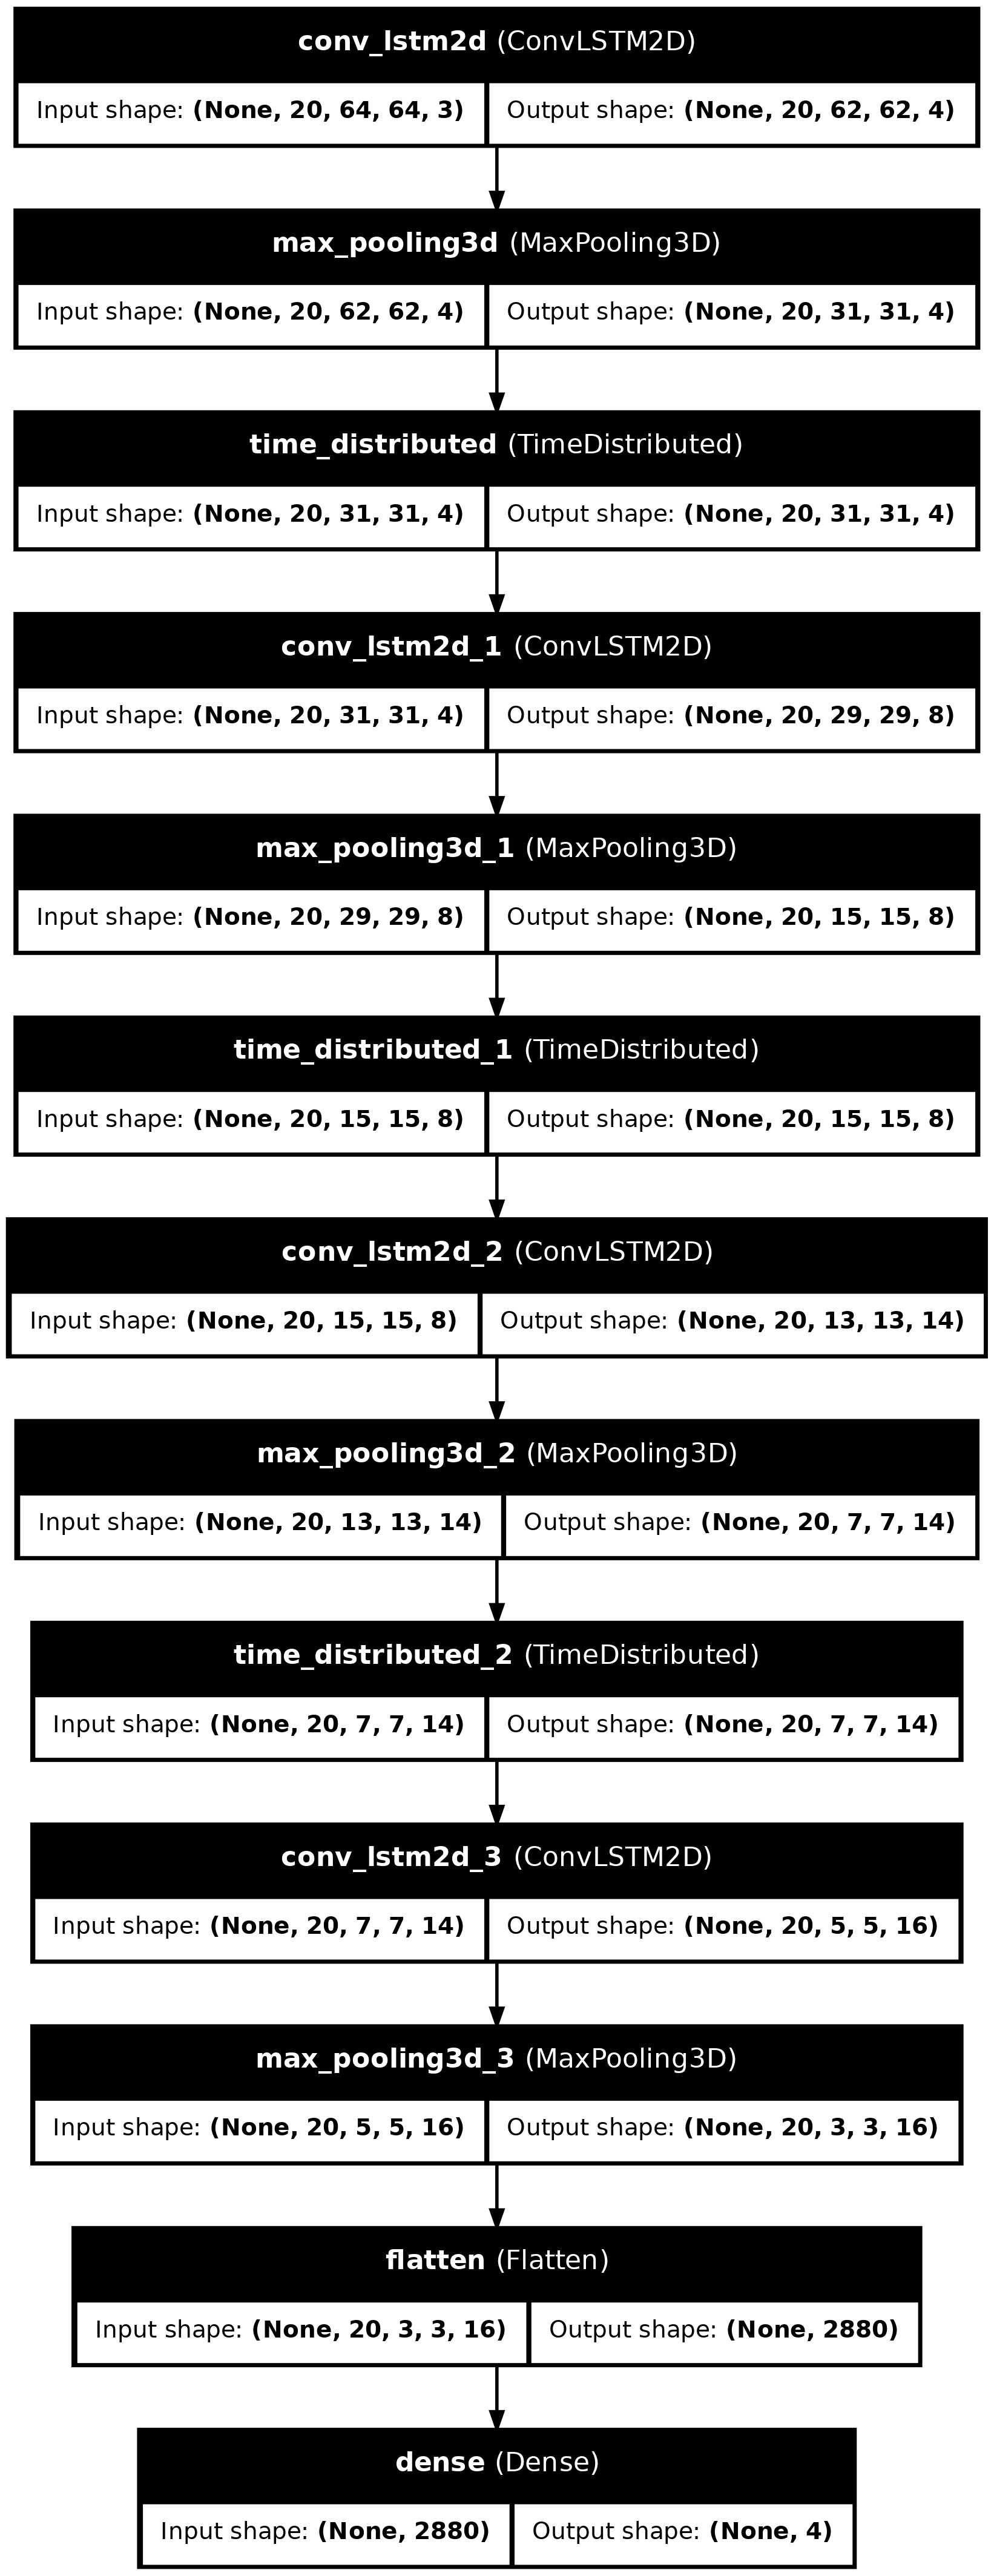

In [22]:
!pip install pydot
!sudo apt install graphviz -y

plot_model(convlstm_model, to_file = model_and_dataset_path + 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

compile and train


In [23]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 4,
                                                      shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 31s 274ms/step - accuracy: 0.2766 - loss: 1.3945 - val_accuracy: 0.1795 - val_loss: 1.3989
Epoch 2/50
55/78 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.3194 - loss: 1.3682

KeyboardInterrupt: 

evaluate


In [24]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.1736 - loss: 1.3913


save


In [17]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
model_path = os.path.join(model_and_dataset_path + 'models', model_file_name)

convlstm_model.save(model_path)

  saving_api.save_model(



loss acuracy plot


In [25]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  epochs = range(len(metric_value_1))

  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  plt.title(str(plot_name))
  plt.legend()


In [27]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

NameError: name 'convlstm_model_training_history' is not defined

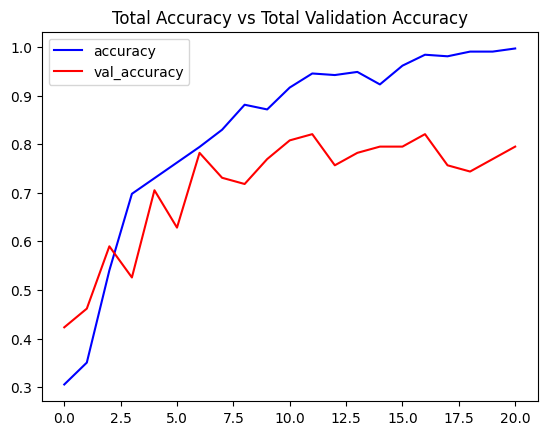

In [20]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

cnn + **LSTM** (LRCN)

In [28]:
def create_LRCN_model():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                            input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  model.summary()
  return model

In [29]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


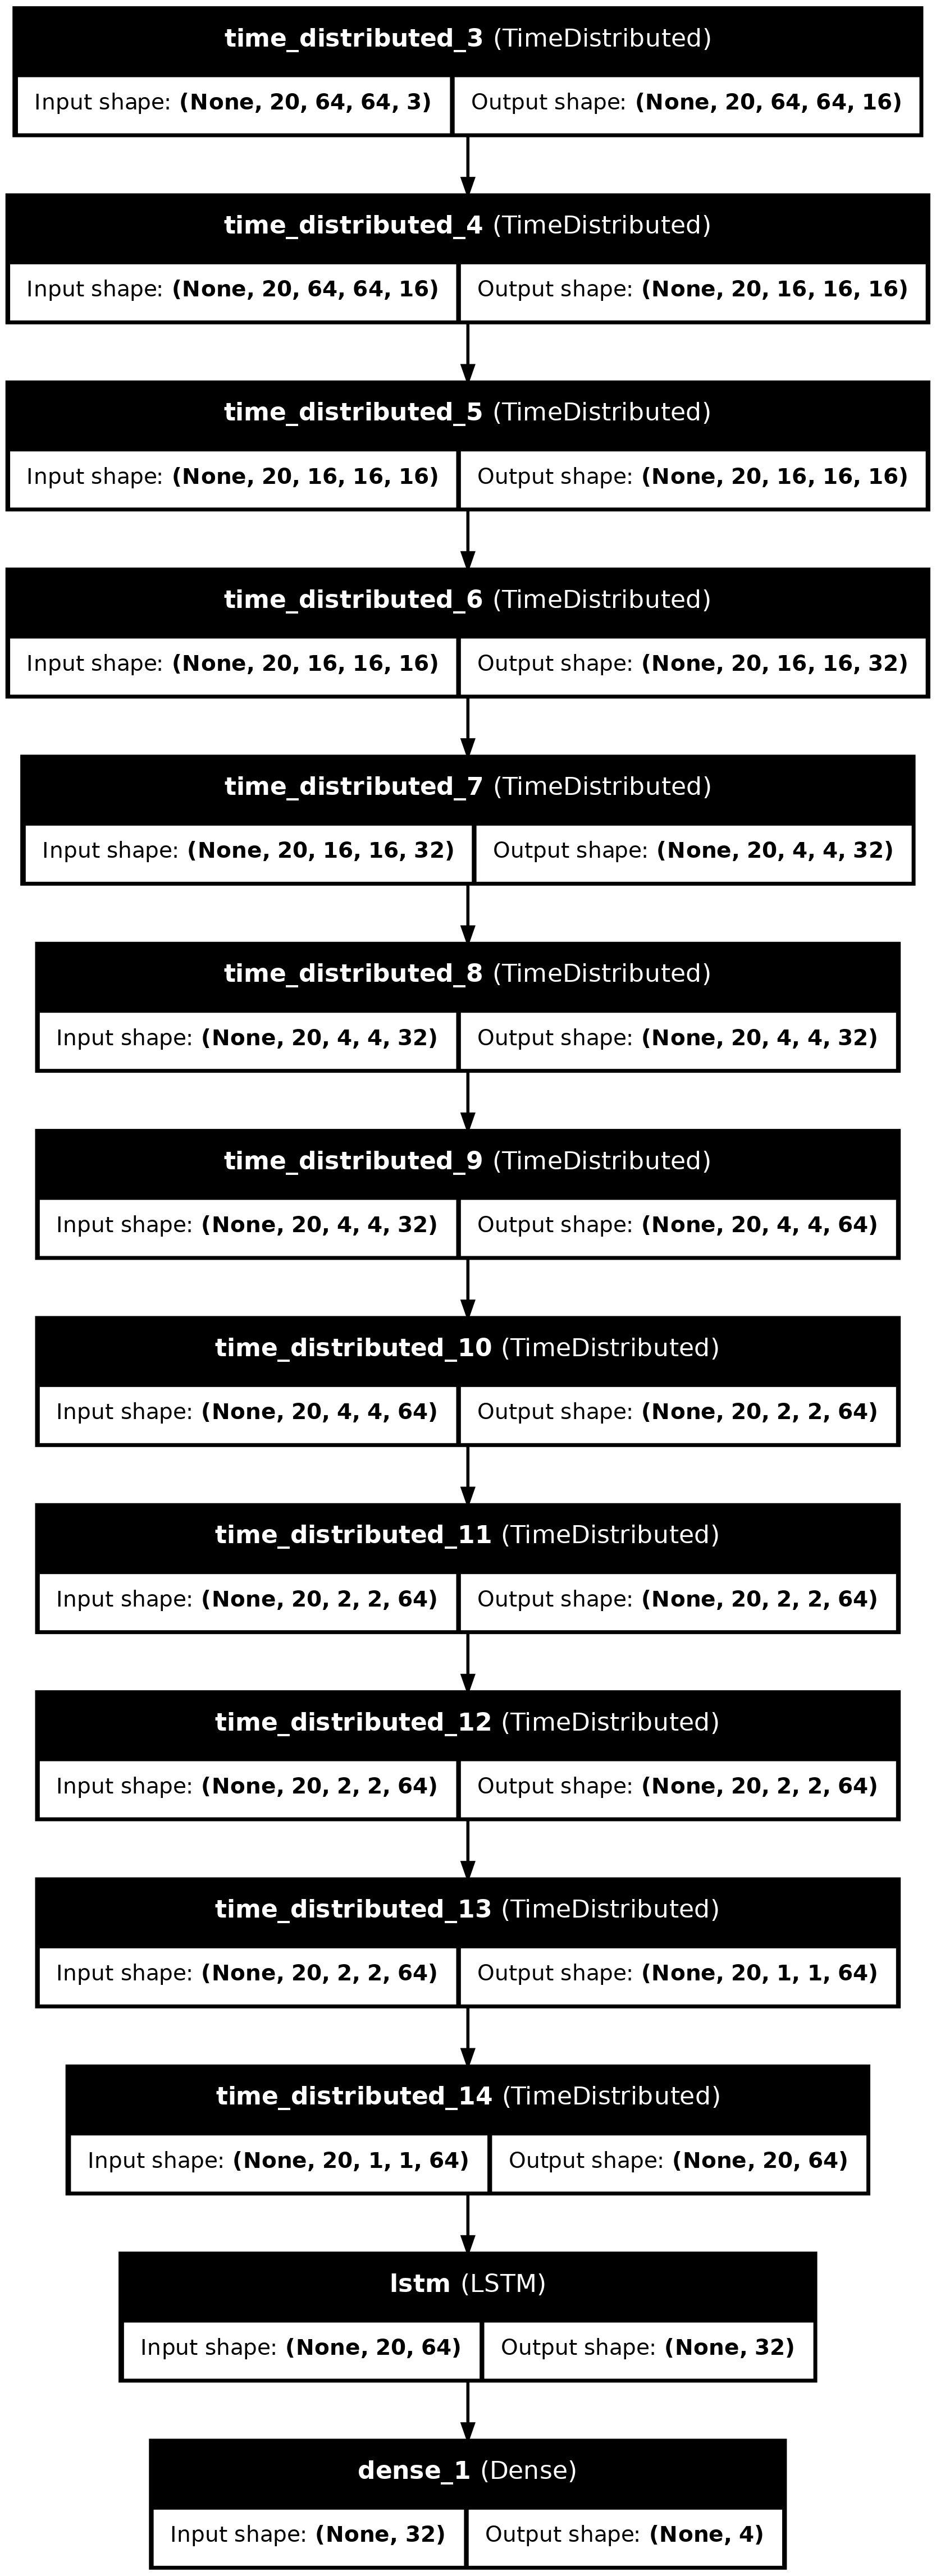

In [30]:
plot_model(LRCN_model, to_file = model_and_dataset_path+'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

compile and run LRCN

In [31]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4,
                                                      shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.2747 - loss: 1.4006 - val_accuracy: 0.2564 - val_loss: 1.3806
Epoch 2/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 113ms/step - accuracy: 0.3171 - loss: 1.3714 - val_accuracy: 0.4744 - val_loss: 1.3512
Epoch 3/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.3498 - loss: 1.3327 - val_accuracy: 0.5000 - val_loss: 1.2018
Epoch 4/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.4589 - loss: 1.1920 - val_accuracy: 0.6410 - val_loss: 1.0443
Epoch 5/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.6087 - loss: 0.9943 - val_accuracy: 0.7564 - val_loss: 0.7515
Epoch 6/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.7283 - loss: 0.7001 - val_accuracy: 0.6026 - val_loss: 0.9684
Epoch 7/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step - accuracy: 0.7174 - loss: 0.6909 - val_accuracy: 0.7692 - val_loss: 0.6700
Epoch 8/70
78/78 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.7468 - loss: 0.6306 - val_accur

In [32]:
# evaluate
model_training_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8729 - loss: 0.5076


In [33]:
# save
model_evaluation_loss, model_evaluation_accuracy = model_training_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
model_path = os.path.join(model_and_dataset_path+'models', model_file_name)

LRCN_model.save(model_path)

In [34]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')


AttributeError: 'list' object has no attribute 'history'

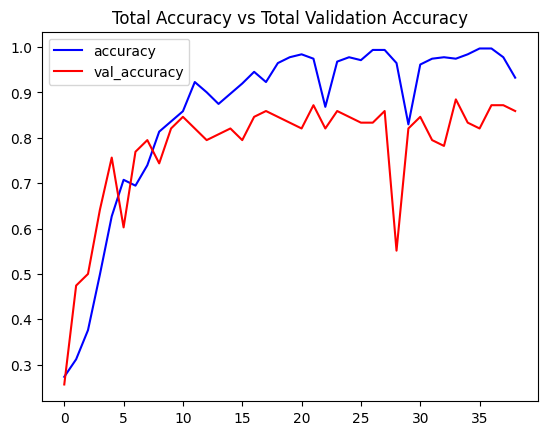

In [35]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

Test model real usecase


In [36]:
def download_youtube_videos(youtube_video_url, output_directory):
  video = pafy.new(youtube_video_url)
  title = video.title
  video_best = video.getbest()
  output_file_path = os.path.join(output_directory, f"{title}.mp4")
  video_best.download(filepath = output_file_path, quiet = True)
  return title

In [40]:
test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok = True)

video_title = download_youtube_videos("https://www.youtube.com/watch?v=8u0qjmHIOcE", test_videos_directory)

input_video_file_path = os.path.join(test_videos_directory, f"{video_title}.mp4")

ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.


OSError: ERROR: Unable to extract uploader id; please report this issue on https://yt-dl.org/bug . Make sure you are using the latest version; see  https://yt-dl.org/update  on how to update. Be sure to call youtube-dl with the --verbose flag and include its complete output.

In [41]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  fps = video_reader.get(cv2.CAP_PROP_FPS)
  num_frames = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), fps, (original_video_width, original_video_height))

  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  predicted_class_name = ''
  while video_reader.isOpened():
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frames_queue.append(normalized_frame)

    if len(frames_queue) == SEQUENCE_LENGTH:
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

      predicted_label = np.argmax(predicted_labels_probabilities)
      predicted_class_name = CLASSES_LIST[predicted_label]

    cv2.putText(frame, text = predicted_class_name, org = (10, 30), fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1, color = (0, 255, 0), thickness = 2)

    video_writer.write(frame)

  video_reader.release()
  video_writer.release

In [43]:
input_video_file_path = os.path.join(test_videos_directory, f"videoplayback.mp4")
output_video_file_path = os.path.join(test_videos_directory, f"videoplayback_predicted.mp4")
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(255,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

TypeError: must be real number, not NoneType

In [44]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)

  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  frames_list = []
  predicted_class_name = ''
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
  for frame_counter in range(SEQUENCE_LENGTH):
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
      success, frame = video_reader.read()
      if not success:
          break
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
      normalized_frame = resized_frame / 255 # 0 ~ 1
      frames_list.append(normalized_frame)

  predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
  predicted_label = np.argmax(predicted_labels_probabilities)
  predicted_class_name = CLASSES_LIST[predicted_label]
  print(f'Action Predicted: {predicted_class_name}')
  video_reader.release()
  return frames_list

In [45]:
# load the local saved model and run inference using it
def load_model_and_predict(model_path, video_file_path, SEQUENCE_LENGTH):
  video_reader = cv2.VideoCapture(video_file_path)
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  frames_list = []
  predicted_class_name = ''
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

  for frame_counter in range(SEQUENCE_LENGTH):
      video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
      success, frame = video_reader.read()
      if not success:
          break
      resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
      normalized_frame = resized_frame / 255 # 0 ~ 1
      frames_list.append(normalized_frame)

  # use the saved model
  model = load_model(model_path)
  predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]
  predicted_label = np.argmax(predicted_labels_probabilities)
  predicted_class_name = CLASSES_LIST[predicted_label]
  print(f'Action Predicted: {predicted_class_name}')
  video_reader.release()
  return frames_list

In [49]:
input_video_file_path = os.path.join(test_videos_directory, f"videoplayback.mp4")
output_video_file_path = os.path.join(test_videos_directory, f"v_BaseballPitch_g01_c01.mp4")
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(output_video_file_path, audio=False, target_resolution=(255,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Action Predicted: Swing


OSError: MoviePy error: the file test_videos/v_BaseballPitch_g01_c01.mp4 could not be found!
Please check that you entered the correct path.